In [1]:
import torch, os
import pandas as pd
from transformers import pipeline, DistilBertForSequenceClassification, DistilBertTokenizerFast
from torch.utils.data import Dataset

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
df = pd.read_csv('/kaggle/input/working-dp/dataset (1).tsv',sep = '\t') 
ls = df.drop(['page_id', 'label'], axis=1)

In [4]:
labels = ls['Pattern Category'].unique().tolist()
labels = [s.strip() for s in labels ]
labels

['Urgency',
 'Not Dark Pattern',
 'Scarcity',
 'Misdirection',
 'Social Proof',
 'Obstruction',
 'Sneaking',
 'Forced Action']

In [5]:
for key, value in enumerate(labels):
    print(value)

Urgency
Not Dark Pattern
Scarcity
Misdirection
Social Proof
Obstruction
Sneaking
Forced Action


In [6]:
NUM_LABELS= len(labels)

id2label={id:label for id,label in enumerate(labels)}

label2id={label:id for id,label in enumerate(labels)}

In [7]:
ls["labels"]=ls['Pattern Category'].map(lambda x: label2id[x.strip()])

<Axes: ylabel='count'>

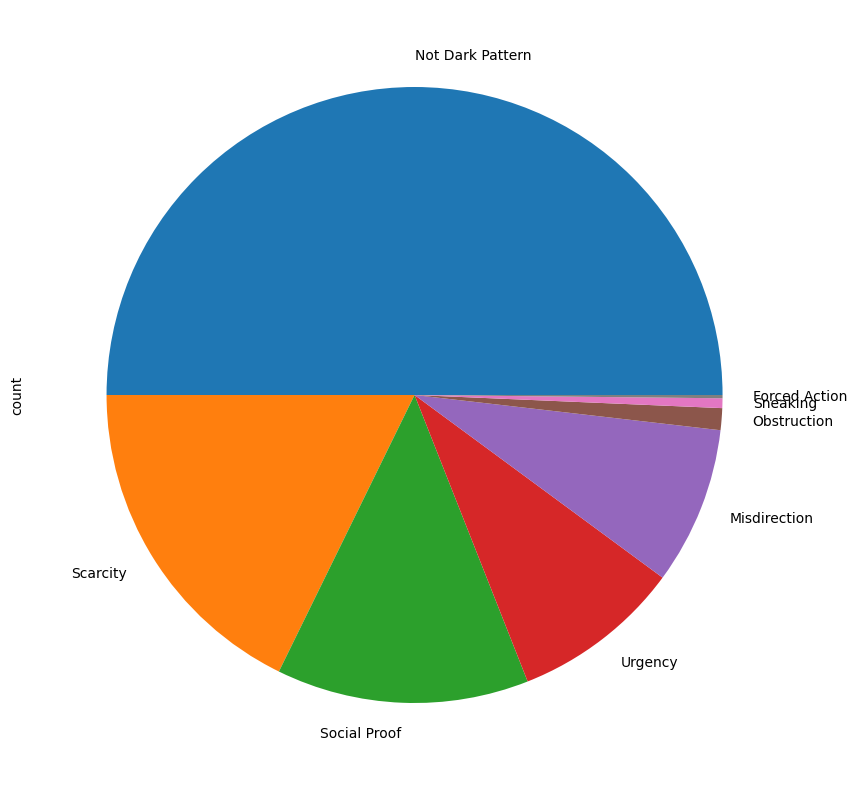

In [8]:
ls['Pattern Category'].value_counts().plot(kind='pie', figsize=(10,10))

In [9]:
tokenizer = DistilBertTokenizerFast.from_pretrained("bert-base-uncased",max_length=150)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizerFast'.


In [10]:
model = DistilBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

You are using a model of type bert to instantiate a model of type distilbert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['transformer.layer.1.attention.q_lin.bias', 'transformer.layer.2.ffn.lin2.bias', 'transformer.layer.10.attention.out_lin.bias', 'transformer.layer.8.sa_layer_norm.weight', 'transformer.layer.10.ffn.lin1.bias', 'transformer.layer.7.output_layer_norm.weight', 'transformer.layer.3.sa_layer_norm.weight', 'transformer.layer.6.attention.q_lin.bias', 'transformer.layer.10.output_layer_norm.bias', 'transformer.layer.0.ffn.lin2.bias', 'transformer.layer.2.sa_layer_norm.weight', 'transformer.layer.5.attention.k_lin.weight', 'transformer.layer.9.attention.v_lin.bias', 'transformer.layer.8.sa_layer_norm.bias', 'transformer.layer.8.ffn.lin1.weight', 'transformer.layer.1.attention.k_lin.weight', 'transformer.layer.0.attention.v_lin.weight', 'transformer.layer.5.ffn.lin1.weight', 'transformer.layer.8.attention.out_lin.weight', 'transformer.layer.9.attenti

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-11): 12 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)

In [11]:
SIZE= ls.shape[0]

train_texts= list(ls.text[:2200])

val_texts=   list(ls.text[2200:])

# test_texts=  list(ls.text[2200:])

train_labels= list(ls.labels[:2200])

val_labels=   list(ls.labels[2200:])

# test_labels=  list(ls.labels[2200:])

In [12]:
len(train_texts), len(val_texts),#len(test_texts)

(2200, 156)

In [13]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
# test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [14]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)


In [15]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

# test_dataset = DataLoader(test_encodings, test_labels)

In [16]:
from transformers import TrainingArguments, Trainer

In [17]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.
    
    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of 
              that observation belonging to a certain class.
              
    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids
    
    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)
    
    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    
    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)
    
    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }


In [18]:
import wandb

In [19]:
wandb.init(project = "distlBERT", config={"hyperparameter": value})

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [22]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./TTC4900Model', 
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0 
    num_train_epochs=10,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory                 
    logging_dir='./multi-class-logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    fp16=True,
    load_best_model_at_end=True
)

In [23]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned 
    model=model,
     # training arguments that we defined above                        
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=val_dataloader,            
    compute_metrics= compute_metrics
)

In [24]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.444000,0.954307,0.679487,0.332611,0.421825,0.411563
100,0.735500,0.464999,0.871795,0.622046,0.625517,0.623707
150,0.427700,0.595088,0.826923,0.563416,0.568860,0.584599
200,0.337200,0.489910,0.871795,0.609771,0.616991,0.608988
250,0.304600,0.380519,0.903846,0.688398,0.784674,0.681655
300,0.249600,0.445394,0.884615,0.664434,0.745434,0.676686
350,0.205700,0.323307,0.935897,0.793272,0.805201,0.785297
400,0.267800,0.388100,0.929487,0.787860,0.802315,0.776368
450,0.135600,0.561683,0.903846,0.689638,0.803556,0.668512
500,0.215400,0.397484,0.916667,0.770367,0.757420,0.786899


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

TrainOutput(global_step=1380, training_loss=0.20024029850095942, metrics={'train_runtime': 459.3567, 'train_samples_per_second': 47.893, 'train_steps_per_second': 3.004, 'total_flos': 2193395468352000.0, 'train_loss': 0.20024029850095942, 'epoch': 10.0})

In [25]:
q=[trainer.evaluate(eval_dataset=ls) for ls in [train_dataloader, val_dataloader]]

pd.DataFrame(q, index=["train","val"]).iloc[:,:5]

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.121154,0.972273,0.702116,0.681106,0.730836
val,0.397484,0.916667,0.770367,0.757420,0.786899


In [26]:
def predict(text):
    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=150, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """

    # Get the index of the class with the highest probability
    # argmax() finds the index of the maximum value in the tensor along a specified dimension.
    # By default, if no dimension is specified, it returns the index of the maximum value in the flattened tensor.
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label 
    # Since pred_label_idx is a tensor containing a single value (the predicted class index), 
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [27]:
text = "Best selling products of 23/24 season kits"
# "Machine Learning itself is moving towards more and more automated"
predict(text)

(tensor([[1.6820e-04, 9.9325e-01, 8.1427e-04, 2.7419e-03, 7.0298e-04, 6.9309e-04,
          1.0339e-03, 5.9283e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor(1, device='cuda:0'),
 'Not Dark Pattern')

In [28]:
model_path = "/kaggle/working/"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('/kaggle/working/tokenizer_config.json',
 '/kaggle/working/special_tokens_map.json',
 '/kaggle/working/vocab.txt',
 '/kaggle/working/added_tokens.json',
 '/kaggle/working/tokenizer.json')

In [29]:
model_path = "/kaggle/working/"


model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer= DistilBertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [30]:
nlp("2 peoplr are viewing.")

[{'label': 'Social Proof', 'score': 0.9966480135917664}]